# <div style = 'background:#E69138; border:2; border-radius: 10px; font-size:150%; font-weight: bold;color:white'> <center> News Articles Topic Modeling </div>

<img src="https://images.unsplash.com/photo-1504711434969-e33886168f5c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80"/>

<a id = "table"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.8;">Table of Contents</div></center>

### [**1. Introduction**](#title-one)

### [**2. Exploratory Data Analysis**](#title-two)

### [**3. Text Preprocessing (NLP)**](#title-three)

### [**4. Model Building & Training**](#title-four) 

### [**5. Conclusions**](#title-five)

### [**6. Reference**](#title-six)

<a id = "title-one"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Introduction</div></center>
Topic modeling is to identify patterns in a text corpus that correspond to document topics. Here we will use a public [dataset](https://www.kaggle.com/competitions/learn-ai-bbc/data) from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech. This dataset is one of the standard benchmarks in machine learning research, and is available for non-commercial and research purposes.

The goal will be to build models that can accurately mine hidden topics from previously unseen news articles. We will build both supervised and unsupervised models and then compare their performance. 

<a id = "title-two"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Exploratory Data Analysis</div></center>

### Importing Necessary Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
plt.rc('axes', titlesize=18)     
plt.rc('axes', labelsize=14)   
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)    
plt.rc('font', size=13)          
import seaborn as sns
sns.set_style('darkgrid') 
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction import _stop_words
import nltk
nltk.download('names')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package names to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/bensmacbookpro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Reading Data

In [2]:
# To aovid any postional issues, I downloaded the files and read them locally.
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')
sample_solutions = pd.read_csv('BBC News Sample Solution.csv')

Let's take a quick look at the train data. 

In [3]:
train.sample(10)

,ArticleId,Text,Category
832,1877,blair joins school sailing trip the prime mini...,politics
775,995,jones medals must go if guilty world anti-do...,sport
64,315,two nigerian banks set to merge nigerian banks...,business
1445,1511,soros group warns of kazakh close the open soc...,business
228,1098,ask jeeves joins web log market ask jeeves has...,tech
1185,1815,disputed nirvana box set on sale a box set fea...,entertainment
901,241,retail sales show festive fervour uk retail sa...,business
850,2072,lesotho textile workers lose jobs six foreign-...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment
1201,1808,english clubs make euro history all four of en...,sport


### Data Cleaning

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


We can see that there are no **null values**. Now let's check if there are any **duplicates**.

In [5]:
train['ArticleId'].duplicated().any()

False

In [6]:
train['Text'].duplicated().any()

True

Let's drop the **duplicates** in `Text`. 

In [7]:
train['Text'].drop_duplicates()

0       worldcom ex-boss launches defence lawyers defe...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens in ...
3       lifestyle  governs mobile choice  faster  bett...
4       enron bosses in $168m payout eighteen former e...
                              ...                        
1485    double eviction from big brother model caprice...
1486    dj double act revamp chart show dj duo jk and ...
1487    weak dollar hits reuters revenues at media gro...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands of ...
Name: Text, Length: 1440, dtype: object

### Getting to Know Data

According to the description, there are **five categories**. Let's double check. 

In [8]:
np.unique(train['Category'])

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

The five categories are **business**, **entertainment**, **politics**, **sport**, **tech**. 

Let's check the number of articles in each category. 

In [9]:
train.groupby('Category').ArticleId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: ArticleId, dtype: int64

It might be easier to visualize the category distribution using a bar graph. 

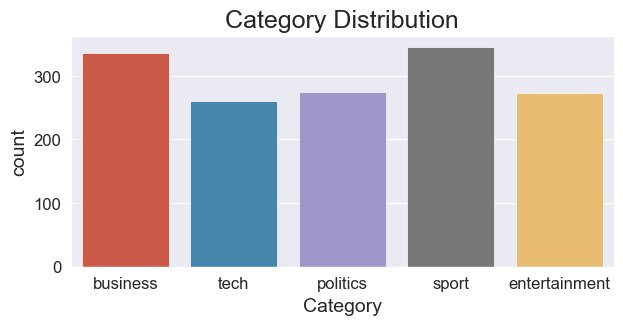

In [10]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.countplot(data = train, x='Category')
plt.title('Category Distribution')
plt.show()

As shown above, different categories have similar amount of articles, so we don't need to worry about imbalance issue. Now let's check the word count.

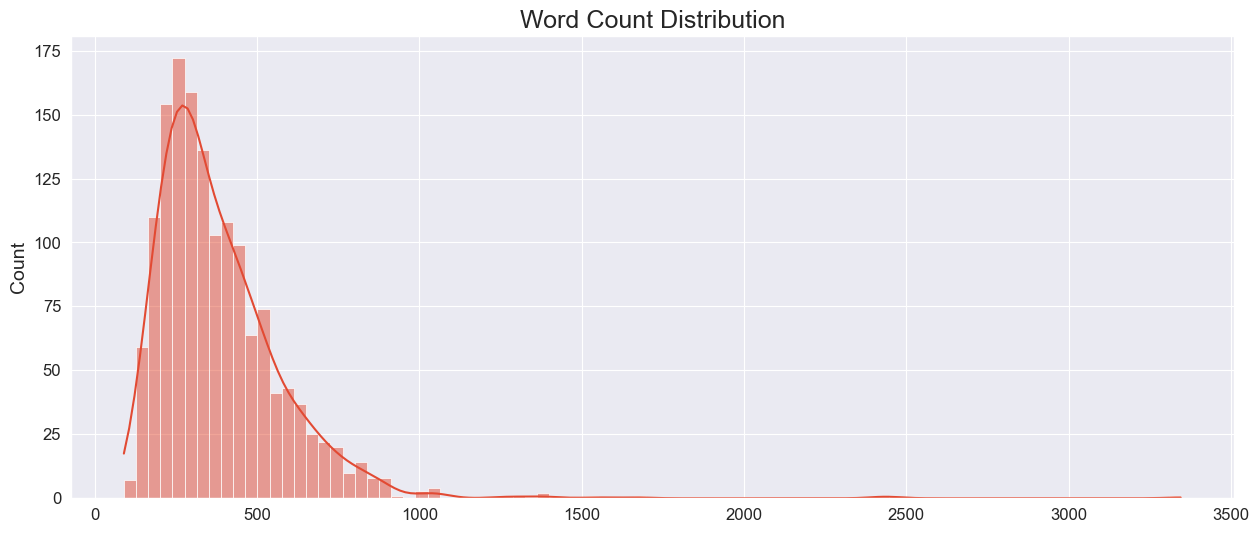

In [11]:
word_counts = []
word_counts.append(len(text.split()) for text in train['Text'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(word_counts, kde=True, legend =False)
plt.title('Word Count Distribution')
plt.show()               

The above histogram shows the overall word count distribution. Now let's check the word count distribution in each category. 

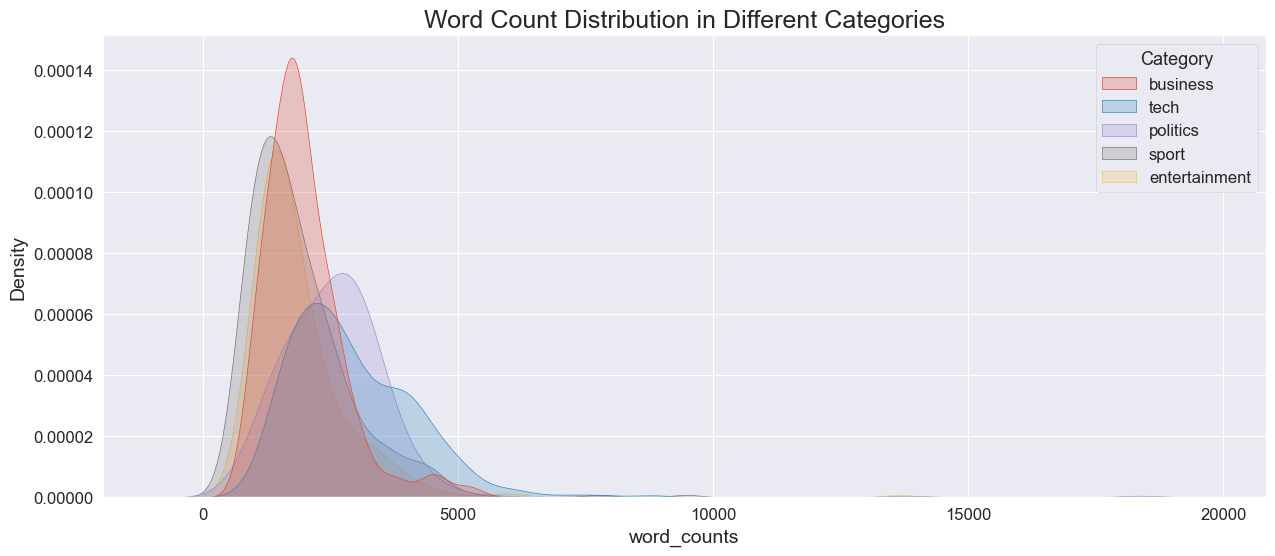

In [12]:
train['word_counts'] = train['Text'].str.len()
fig, ax = plt.subplots(figsize=(15, 6))
sns.kdeplot(data = train, x='word_counts', hue='Category',fill=True)
plt.title('Word Count Distribution in Different Categories')
plt.show() 

<a id = "title-three"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Text Preprocessing (NLP)</div></center>

### Removing Stop Words

Stop words are those common words that provide little value in helping to differentiate documents (see the list below). In general, stop words add noise to the Bag of Words (BoW) model and can be removed. We don't remove stop words at this step. We will just need to specify the `stop_words` parameter when we use the `TfidfVectorizer` class from scikit-learn (see the next session below)

In [13]:
print(_stop_words.ENGLISH_STOP_WORDS)

frozenset({'whereby', 'while', 'side', 'seem', 'thence', 'interest', 'many', 'hereafter', 'least', 'whose', 'could', 'either', 'front', 'detail', 'latter', 'mill', 'whole', 'onto', 'amount', 'per', 'twenty', 'since', 'anyone', 'same', 'each', 'ever', 'behind', 'has', 'elsewhere', 'here', 'and', 'from', 'i', 'me', 'next', 'inc', 'what', 'both', 'sometimes', 'much', 'is', 'put', 'thru', 'must', 'along', 'only', 'somewhere', 'last', 'co', 'eleven', 'system', 'someone', 'thick', 'when', 'other', 'another', 'your', 'own', 'themselves', 'take', 'all', 'himself', 'therein', 'although', 'enough', 'because', 'anyway', 'my', 'further', 'throughout', 'found', 'however', 'made', 'two', 'before', 'him', 'off', 'eg', 'un', 'become', 'de', 'that', 'anywhere', 'twelve', 'which', 'mostly', 'due', 'seeming', 'she', 'almost', 'often', 'are', 'herein', 'formerly', 'fire', 'how', 'through', 'again', 'whatever', 'others', 'five', 'together', 'to', 'wherever', 'back', 'he', 'with', 'yourselves', 'see', 'a', 

Besides stop word removal, we will also perform the following steps to reduce the inflectional and derivational forms of words. Note that we will use lemmatization instead of stemming, as it is more accurate.

- **Lemmatization**

- **Removing numbers and letter-number combinations**

- **Removing names**

- **Removing words with only one or two letters**

In [14]:
train_cleaned = []
lemmatizer = WordNetLemmatizer()
all_names = set(names.words())
for text in train['Text']:
    text = text.lower()
    text_cleaned = ' '.join(lemmatizer.lemmatize(word) # lemmatization
                            for word in text.split()
                            if word.isalpha()  # remove numbers and letter-number combinations
                            and word not in all_names # remove names
                            and len(word)>3) # words with only one or two letters
    train_cleaned.append(text_cleaned)

Now we have the "cleaned" texts. Let's take a quick look at the words from the first article. 

In [15]:
train_cleaned[0]

'worldcom launch defence lawyer defending former worldcom chief bernie ebbers against battery fraud charge have called company whistleblower their first cynthia cooper worldcom internal accounting alerted director irregular accounting practice telecom giant warning collapse firm following discovery accounting ebbers pleaded guilty charge fraud prosecution lawyer have argued that ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings cooper run consulting business told jury york wednesday that external auditor arthur andersen approved worldcom accounting early said andersen given green light procedure practice used ebber lawyer have said unaware fraud arguing that auditor alert cooper also said that during shareholder meeting ebbers often passed over technical question company finance chief giving only brief answer prosecution star witness former worldcom financial chief scott sullivan said that ebbers ordered accoun

<a id = "title-four"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Model Building & Training</div></center>

### Feature Extraction

Here we need to convert texts into a matrix where each row represents a BBC news article and each column is a word token. There are multiple approaches to extract features from text in natural language processing (NLP). For example, `word embedding` and `term frequency-inverse document frequency (tf-idf)`. `Word embedding` is able to capture the meanings of words in their context, but it is memory-intensive and more suitable to analyze documents with small size of vocabulary. According to the above EDA, we are dealing with a large amount of news articles with a big size of vocabulary, so we will use the easier and more traditional approach, `tf-idf`. 

`Tf-idf` considers each document of words (terms) a collection of words, or a bag of words (BoW). It uses the counts of tokens and assigns each tf a weighting factor that is inversely proportionally to the document frequency. With the idf fator included, this method diminishes the weight of common words (such as "month" and "come") that occur frequently, and emphasizes words that rarely occur but convey important information. In this project, we will take advantage of the TfidfVectorizer class from scikit-learn to perform feature extraction. 

In [16]:
features_n = 2000
# As mentioned earlier, here we specify the parameter stop_words as "english" to remove the stop words
tfidf_vector = TfidfVectorizer(stop_words='english', max_features=features_n, max_df=0.95, min_df=2)

In [17]:
tfidf_matrix = tfidf_vector.fit_transform(train_cleaned)

In [18]:
tfidf_matrix

<1490x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 113789 stored elements in Compressed Sparse Row format>

### Non-Negative Matrix Factorization (NMF)

Next, we will use a popular topic modeling algorithm, `non-negative matrix factorization (NMF)`, to mine hidden topic in the news articles. 

NMF factorizes an input matrix, `V`, into a product of two smaller matrices, `W` and `H`, in such a way that these three matrices have no negative values. In the context of this project, these three matrices have the following meanings:

- The input matrix `V` is the word (term) count or tf-idf matrix of size n x m, where n is the number of documents and m is the number of words (terms).

- The first decomposition output matrix `W` is the coefficient matrix of size n x t. Each row of `W` represents a document, with each element in the row representing the weight of a topic within the document.

- The second decomposition output matrix `H` is the feature matrix of size t x m, where t is the number of topics specified. Each row of `H` represents a topic with each element in the row representing the rank of a term in the topic.


In [19]:
# build the NMF model
topic_n =5
nmf = NMF(n_components=topic_n, random_state=2022)

In [20]:
# fit the NMF model nmf on the tfidf matrix data
nmf.fit(tfidf_matrix)

NMF(n_components=5, random_state=2022)

Let's check the top 10 words based on their ranks in each topic.

In [21]:
words = tfidf_vector.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f'Topic {topic_idx}')
    print(' '.join([words[i] for i in topic.argsort()[-10:]]))

Topic 0
rate bank share economy market sale company firm growth said
Topic 1
nomination festival director actress star oscar actor award best film
Topic 2
said howard government minister brown tory party election blair labour
Topic 3
world team play champion match ireland wale player england game
Topic 4
gadget said digital user service music technology people phone mobile


**This is very promising!**

We could easily tell that topics 0 to 4 are 'business', 'entertainment', 'politics', 'sport', and 'tech', respectively! 

In [22]:
# top-feature rank
nmf.components_

array([[0.00778061, 0.01612073, 0.01093809, ..., 0.        , 0.18582411,
        0.        ],
       [0.00133318, 0.01430087, 0.00862499, ..., 0.00392154, 0.        ,
        0.        ],
       [0.02517282, 0.03307176, 0.02381508, ..., 0.01214761, 0.        ,
        0.        ],
       [0.01185233, 0.03705873, 0.02359824, ..., 0.01213855, 0.        ,
        0.06560404],
       [0.03329941, 0.08745475, 0.        , ..., 0.0136712 , 0.        ,
        0.        ]])

`W` is the coefficient matrix of size n x t. Each row of `W` represents a BBC article, with each element in the row representing the weight of a topic within the document.

In [23]:
W = nmf.fit_transform(tfidf_matrix)
W

array([[0.0463311 , 0.00531251, 0.00245952, 0.00368393, 0.01133083],
       [0.1466117 , 0.        , 0.        , 0.        , 0.        ],
       [0.0952225 , 0.00073719, 0.03369601, 0.02245362, 0.01895822],
       ...,
       [0.10827237, 0.00695314, 0.        , 0.00685917, 0.        ],
       [0.01092026, 0.01023797, 0.        , 0.        , 0.24765746],
       [0.00181045, 0.        , 0.        , 0.0013243 , 0.11830499]])

In each row of the above array, the index of the element with the highest weight is the predicted topic.

In [24]:
# For each row of the above array, get the index of the element with the highest weight
predicted_topics = [np.argsort(coefficients)[::-1][0] for coefficients in W]

Note here the topic categories are shown as number 0, 1, 2, 3, and 4. Let's take the first article and the last one as examples. 

In [25]:
print(f"The predicted topic of the first article is: {predicted_topics[0]}.")
print(f"The predicted topic of the last article is: {predicted_topics[-1]}.")

The predicted topic of the first article is: 0.
The predicted topic of the last article is: 4.


Now let's see how good the model is by checking the **accuracy** score. 

In [26]:
def label_permute_compare(ytdf,yp,n=5):
    """
    A helper function that helps calculate the accuracy based on the predicted results. 
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    best_accuracy = 0
    ori_label = np.unique(ytdf['Category'])
    for label_permute in list(itertools.permutations(range(5))):
        y_true = ytdf['Category'].replace(ori_label, label_permute)
        accuracy = accuracy_score(y_true, yp)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            label_order = label_permute
    return label_order, best_accuracy        

In [27]:
best_accuracy = 0
ori_label = np.unique(train['Category'])
for label_permute in list(itertools.permutations(range(5))):
    y_true = train['Category'].replace(ori_label, label_permute)
    accuracy = accuracy_score(y_true, predicted_topics)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        label_order = label_permute
print(label_order)
print(ori_label)
print(f"\n The accuracy score: {best_accuracy.round(2)}!")

(0, 1, 2, 3, 4)
['business' 'entertainment' 'politics' 'sport' 'tech']

 The accuracy score: 0.91!


### Hyperparameter Optimization

We get an accuracy of 0.91 which is not bad. Next we will perform some hyperparameter tuning to try to improve the accuracy score. We will mainly focus on three parameters, `l1_ratio`, `alpha_w`, and `alpha_H` (same as alpha_w). 

In [28]:
# Create a table to visualize the tuning results.
hparam_tuning = pd.DataFrame(columns = ['l1_ratio','alpha_w', 'accuracy'])

In [29]:
%%capture --no-display
def NMF_GridSearch(hparam_tuning):
    for l1_ratio in np.arange(0, 1.1, 0.3):
        for alpha_w in np.arange(0, 1.1, 0.3):
            nmf = NMF(n_components = 5, random_state=42, max_iter=10000,
                      alpha_W=alpha_w, alpha_H = 'same', l1_ratio=l1_ratio)
            W = nmf.fit_transform(tfidf_matrix)
            predicted_topics = [np.argsort(coefficients)[::-1][0] for coefficients in W]
            permutation_accuracy = label_permute_compare(train,predicted_topics,n=5)
            accuracy = permutation_accuracy[1]
            hparam_tuning.loc[len(hparam_tuning.index)] = [l1_ratio, alpha_w, accuracy]
    print(hparam_tuning)     

In [30]:
confusion = confusion_matrix(y_true, predicted_topics)
print(f"Confusion Matrix:\n {confusion}")

Confusion Matrix:
 [[  1   4   1  17 238]
 [  0   2   0 344   0]
 [  8   0 250  10   6]
 [  5 212   3  15  38]
 [309   1   6   5  15]]


The table below summarizes the tuning results. Here we try to use different parameter values, for example, l1_ratio= 0.6 and alpha_w = 0, but it seems that we are not able to further improve the accuracy score. 

In [31]:
NMF_GridSearch(hparam_tuning)

    l1_ratio  alpha_w  accuracy
0        0.0      0.0  0.908054
1        0.0      0.3  0.232215
2        0.0      0.6  0.232215
3        0.0      0.9  0.232215
4        0.3      0.0  0.908054
5        0.3      0.3  0.232215
6        0.3      0.6  0.232215
7        0.3      0.9  0.232215
8        0.6      0.0  0.908054
9        0.6      0.3  0.232215
10       0.6      0.6  0.232215
11       0.6      0.9  0.232215
12       0.9      0.0  0.908054
13       0.9      0.3  0.232215
14       0.9      0.6  0.232215
15       0.9      0.9  0.232215


## Comparison with Supervised Learning Models

Next we will compare the unsupervised learning model with some supervised learning models. 

### Random Forest Model

In [32]:
def random_forest(test_size):
    X_train, X_test, y_train, y_test = train_test_split(train['Text'], train['Category'], 
                                       test_size=test_size, random_state=2022)
    X_train = tfidf_vector.transform(X_train)
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    X_test = tfidf_vector.transform(X_test)
    y_test = label_encoder.fit_transform(y_test)
    random_forest = RandomForestClassifier(max_depth=5, random_state=2022)
    rf_model = random_forest.fit(X_train, y_train)

    acc = accuracy_score(y_test, rf_model.predict(X_test))
    y_pred = rf_model.predict(X_test)
    return y_test, y_pred, acc

In [33]:
%time
RF_df = pd.DataFrame(columns = ['Test Size(%)','Accuracy'])
for i in np.arange(0.1,1,0.1):
    y_test, y_pred, acc = random_forest(i)
    RF_df.loc[len(RF_df.index)] = [i*100, acc]
    confusion = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix, Test Size ={i.round(2)}")
    print(confusion)
RF_df

CPU times: user 22 µs, sys: 4 µs, total: 26 µs
Wall time: 7.15 µs

 Confusion Matrix, Test Size =0.1
[[27  0  0  0  2]
 [ 4 25  2  2  2]
 [ 1  1 22  0  1]
 [ 2  0  0 30  0]
 [ 3  0  0  0 25]]

 Confusion Matrix, Test Size =0.2
[[61  0  1  0  1]
 [ 9 50  2  8  3]
 [ 5  0 42  1  1]
 [ 1  0  1 65  0]
 [ 3  1  0  0 43]]

 Confusion Matrix, Test Size =0.3
[[94  0  2  0  1]
 [14 63  1  6  7]
 [ 8  0 66  1  1]
 [ 5  0  2 99  0]
 [ 5  1  0  2 70]]

 Confusion Matrix, Test Size =0.4
[[125   0   2   0   1]
 [ 17  88   1   6   4]
 [ 10   0  96   2   1]
 [  7   1   1 132   0]
 [  8   1   0   2  91]]

 Confusion Matrix, Test Size =0.5
[[155   0   1   0   6]
 [ 22 100   1   9  10]
 [ 11   0 121   3   2]
 [  9   1   1 166   0]
 [ 12   1   0   1 113]]

 Confusion Matrix, Test Size =0.6
[[193   0   4   2   5]
 [  9 134   1  16   3]
 [ 14   0 142   8   2]
 [  4   0   2 198   0]
 [ 11   2   0   5 139]]

 Confusion Matrix, Test Size =0.7
[[224   0   3   2   5]
 [ 18 147   2  17   5]
 [ 22   0 168   4   2]

,Test Size(%),Accuracy
0,10.0,0.865772
1,20.0,0.875839
2,30.0,0.875000
3,40.0,0.892617
4,50.0,0.879195
5,60.0,0.901566
6,70.0,0.890700
7,80.0,0.890940
8,90.0,0.832960


### Logistic Regression

In [34]:
def logistic_regression(test_size):
    X_train, X_test, y_train, y_test = train_test_split(train['Text'], train['Category'], 
                                       test_size=test_size, random_state=2022)
    X_train = tfidf_vector.transform(X_train)
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    X_test = tfidf_vector.transform(X_test)
    y_test = label_encoder.fit_transform(y_test)
    logistic_regression = LogisticRegression(C=1e5)
    lr_model = logistic_regression.fit(X_train, y_train)
    acc = accuracy_score(y_test, lr_model.predict(X_test))
    y_pred = lr_model.predict(X_test)
    return y_test, y_pred, acc

In [35]:
%time
LR_df = pd.DataFrame(columns = ['Test Size(%)','Accuracy'])
for i in np.arange(0.1,1,0.1):
    y_test, y_pred, acc = logistic_regression(i)
    LR_df.loc[len(LR_df.index)] = [i*100, acc]
    confusion = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix, Test Size ={i.round(2)}")
    print(confusion)
LR_df

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs

 Confusion Matrix, Test Size =0.1
[[28  0  0  0  1]
 [ 1 33  1  0  0]
 [ 0  0 24  0  1]
 [ 0  0  1 31  0]
 [ 1  0  0  0 27]]

 Confusion Matrix, Test Size =0.2
[[61  0  1  0  1]
 [ 2 67  2  0  1]
 [ 3  0 45  0  1]
 [ 0  0  0 67  0]
 [ 1  1  0  0 45]]

 Confusion Matrix, Test Size =0.3
[[ 95   0   1   0   1]
 [  3  84   1   1   2]
 [  3   1  71   0   1]
 [  1   0   1 104   0]
 [  2   1   0   0  75]]

 Confusion Matrix, Test Size =0.4
[[124   0   2   0   2]
 [  3 109   1   1   2]
 [  3   1 103   1   1]
 [  1   0   2 138   0]
 [  3   1   1   0  97]]

 Confusion Matrix, Test Size =0.5
[[158   0   2   0   2]
 [  3 135   2   1   1]
 [  3   1 131   1   1]
 [  1   0   2 174   0]
 [  3   1   1   0 122]]

 Confusion Matrix, Test Size =0.6
[[197   0   4   1   2]
 [  3 156   0   1   3]
 [  4   1 159   1   1]
 [  1   0   2 201   0]
 [  2   1   1   0 153]]

 Confusion Matrix, Test Size =0.7
[[224   0   4   1   5]
 [  3 181   2 

,Test Size(%),Accuracy
0,10.0,0.959732
1,20.0,0.956376
2,30.0,0.957589
3,40.0,0.958054
4,50.0,0.966443
5,60.0,0.968680
6,70.0,0.962608
7,80.0,0.951342
8,90.0,0.926174


<a id = "title-five"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Conclusions</div></center>

###  <center> Comparison between NMF and unsupervised learning models

|Model|Accuracy Score||
|----|----|----|
|Non-negative matrix factorization|0.91|
|Random Forest|0.90|
|Logistic Regression|0.97|

- It seems that supervised learning (Logistic Regression) performs better (higher accuracy score) compared to unsupervised learning (NMF). 
- In terms of data efficiency, for the current dataset, it seems that Logistic Regression is better than Random Forest. 
- When we changed the train/test data size, for both Random Forest and Logistic Regression, they began to show overfitting if the training data set is higher than 40%. 

<a id = "title-six"></a>
# <center><div style="border-radius : 10px; background-color: #E69138; color: white; padding: 12px; line-height: 0.6;">Reference</div></center>

https://images.unsplash.com/photo-1504711434969-e33886168f5c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80

https://predictivehacks.com/topic-modelling-with-nmf-in-python/

https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

https://notebook.community/davidgutierrez/HeartRatePatterns/Jupyter/Non-Negative%20Matrix%20Factorization%20(NMF)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

Yuxi Liu, Python Machine Learning By Example, 2020

### ☝️ [**Back to Table of Contents**](#table)